In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch

import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable

import os
import sys

sys.path.insert(0, "./../")
from FileManager import FileManager
from misc import rcsetup
rcsetup()

In [2]:
def get_color(x, cmap='hsv'):
    return plt.colormaps[cmap](x)

def darken_color(color, amount=0.33):
    amount = float(max(0.0, min(1.0, amount)))
    rgb = mpl.colors.to_rgb(color)
    hsv = mpl.colors.rgb_to_hsv(rgb)
    hsv[2] = max(0.0, hsv[2] * (1.0 - amount))
    return tuple(mpl.colors.hsv_to_rgb(hsv))

In [3]:
class Vocabulary:

    def __init__(self, word_counts):
        self.words = np.array([word for word, c in word_counts])
        self.counts = np.array([c for word, c in word_counts])
        self.word2token = {word:tok for tok, word in enumerate(self.words)}
        self.size = len(self.words)

    def get_count(self, word):
        if word not in self.word2token:
            return 0
        return self.counts[self.word2token.get(word)]

    def to_words(self, tokens):
        return " ".join([self.words[tok] for tok in tokens])

# pull files

In [4]:
VOCAB_SZ = 25_000
data_dir = os.path.join(os.getenv("DATASETPATH"), "enwiki", "min200")

data_fm = FileManager(data_dir)
word_counts = data_fm.load("word_counts.pickle")
vocab = Vocabulary(word_counts)

In [5]:
print(f"Computing M*... ", end="")
corpus_stats = data_fm.load("corpus_stats.pickle")
cL = corpus_stats["context_len"]
Cij, Crwij = corpus_stats["counts"], corpus_stats["counts_reweight"]
numcounts = Cij[:VOCAB_SZ, :VOCAB_SZ].sum()
Pij = Crwij[:VOCAB_SZ, :VOCAB_SZ] / (numcounts * (cL + 1)/2)
unigram = vocab.counts[:VOCAB_SZ] / vocab.counts[:VOCAB_SZ].sum()
PiPj = np.outer(unigram, unigram)
Mstar = 2*(Pij - PiPj)/(Pij + PiPj)
print("done.")

Computing M*... done.


In [60]:
M_gpu = torch.tensor(Mstar, dtype=torch.float32).cuda()
eigvals = torch.linalg.eigvalsh(M_gpu)
eigvals = eigvals.cpu().numpy().astype(np.float64)
del M_gpu
torch.cuda.empty_cache()

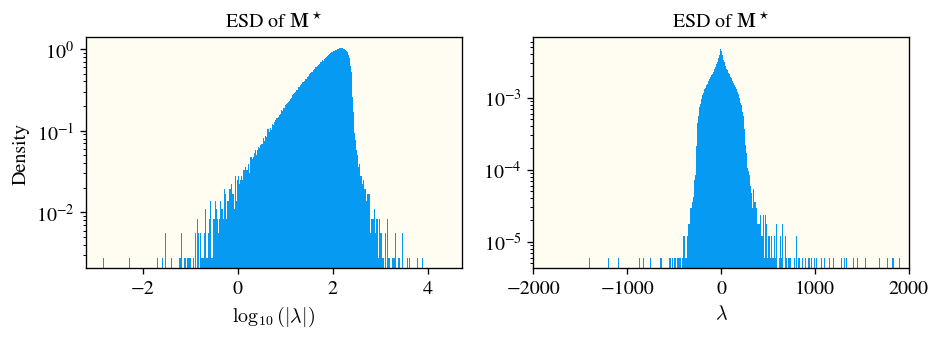

In [63]:
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(8,3))
axes = axes.flat

ax = axes[0]
log_eigvals = np.log10(np.abs(eigvals))
signs = np.sign(eigvals)
ax.hist(log_eigvals, bins=500, density=True, color="xkcd:azure")
ax.set_ylabel("Density")
ax.set_yscale("log")
ax.set_xlabel(f"$\\log_{{10}}(|\\lambda|)$")
ax.set_title(f"ESD of $\\mathbf{{M}}^\\star$")

ax = axes[1]
xlim = 2000
eigvals_lim = eigvals[np.abs(eigvals) < xlim]
ax.hist(eigvals_lim, bins=500, density=True, color="xkcd:azure")
ax.set_yscale("log")
ax.set_xlim(-xlim, xlim)
ax.set_xlabel(f"$\\lambda$")
ax.set_title(f"ESD of $\\mathbf{{M}}^\\star$")

plt.tight_layout()
plt.show()

In [47]:
M = Pij/PiPj
M_gpu = torch.tensor(M, dtype=torch.float32).cuda()
eigvals = torch.linalg.eigvalsh(M_gpu)
eigvals = eigvals.cpu().numpy().astype(np.float64)
del M_gpu
torch.cuda.empty_cache()

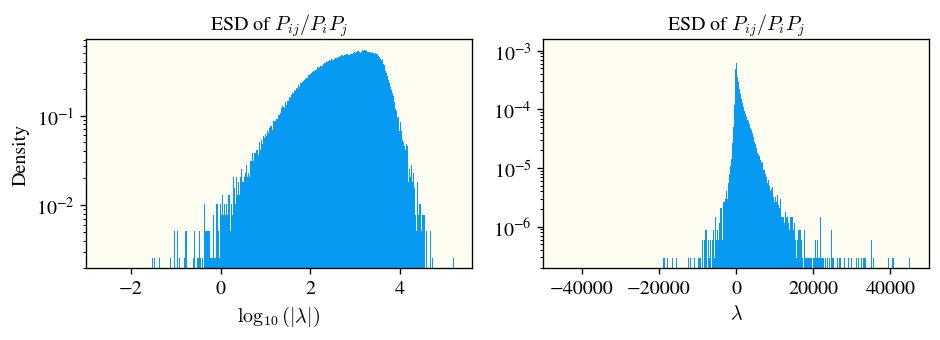

In [50]:
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(8,3))
axes = axes.flat

ax = axes[0]
log_eigvals = np.log10(np.abs(eigvals))
signs = np.sign(eigvals)
ax.hist(log_eigvals, bins=500, density=True, color="xkcd:azure")
ax.set_ylabel("Density")
ax.set_yscale("log")
ax.set_xlabel(f"$\\log_{{10}}(|\\lambda|)$")
ax.set_title(f"ESD of $P_{{ij}}/P_i P_j$")

ax = axes[1]
xlim = 50000
eigvals_lim = eigvals[np.abs(eigvals) < xlim]
ax.hist(eigvals_lim, bins=500, density=True, color="xkcd:azure")
ax.set_yscale("log")
ax.set_xlim(-xlim, xlim)
ax.set_xlabel(f"$\\lambda$")
ax.set_title(f"ESD of $P_{{ij}}/P_i P_j$")

plt.tight_layout()
plt.show()

In [51]:
PMI = np.log(Pij/PiPj + 1e-5)
M_gpu = torch.tensor(PMI, dtype=torch.float32).cuda()
eigvals = torch.linalg.eigvalsh(M_gpu)
eigvals = eigvals.cpu().numpy().astype(np.float64)
del M_gpu
torch.cuda.empty_cache()

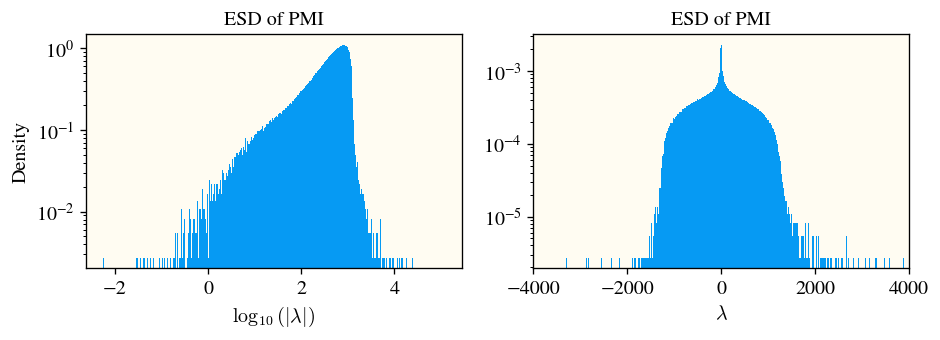

In [59]:
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(8,3))
axes = axes.flat

ax = axes[0]
log_eigvals = np.log10(np.abs(eigvals))
signs = np.sign(eigvals)
ax.hist(log_eigvals, bins=500, density=True, color="xkcd:azure")
ax.set_ylabel("Density")
ax.set_yscale("log")
ax.set_xlabel(f"$\\log_{{10}}(|\\lambda|)$")
ax.set_title(f"ESD of PMI")

ax = axes[1]
xlim = 4000
eigvals_lim = eigvals[np.abs(eigvals) < xlim]
ax.hist(eigvals_lim, bins=500, density=True, color="xkcd:azure")
ax.set_yscale("log")
ax.set_xlim(-xlim, xlim)
ax.set_xlabel(f"$\\lambda$")
ax.set_title(f"ESD of PMI")

plt.tight_layout()
plt.show()